In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import os 
import random

**Using CV2 cascades to find face and eyes from the images**

In [11]:
eyes_cascade_path = os.path.abspath('haarcascade_eye.xml')
face_cascade_path = os.path.abspath('haarcascade_frontalface_default.xml')

In [12]:
eye_cascade = cv2.CascadeClassifier(eyes_cascade_path)
face_cascade = cv2.CascadeClassifier(face_cascade_path)


In [13]:
labels = ['Christian Bale','Johnny Depp','Leonardo Dicaprio','Matt Damon']
files_names = []
for label in labels:
    file_path = os.path.join('./'+label)
    for img in os.listdir(file_path):
        if img[-4:]!='.jpg':
            os.remove(os.path.join(file_path,img))
        else:
            files_names.append(os.path.join(file_path,img))

In [4]:
files_names

['./Christian Bale\\1200px-Christian_Bale_2009.jpg',
 './Christian Bale\\12441_v9_bb.jpg',
 './Christian Bale\\16525779265472.jpg',
 './Christian Bale\\1C5696424-120909-christian-bale.jpg',
 './Christian Bale\\20120721__20120722_A26_ND22MOVIESp1.jpg',
 './Christian Bale\\220707174235-christian-bale-file-062322.jpg',
 './Christian Bale\\230228102741-01b-christian-bale-makeup-90s-restricted.jpg',
 './Christian Bale\\2K20AH6.jpg',
 './Christian Bale\\459896580.jpg',
 './Christian Bale\\558678178049.jpg',
 './Christian Bale\\6-Christian-Bale.jpg',
 './Christian Bale\\7ea3851c2c9966507654fb44df605acc-1200-80.jpg',
 './Christian Bale\\81mLGs6phBS._AC_UF10001000_QL80_.jpg',
 './Christian Bale\\AcfW3p5D6ov573fABLyGqwYdolD.jpg',
 './Christian Bale\\AGvuzYbytZ8hA1JgaVUP1_bnYkfiRoYRTdgVGbuht_8s64-c-mo.jpg',
 './Christian Bale\\american-psycho-christian-bale-tom-cruise.jpg',
 './Christian Bale\\bale-wallstpsychos.jpg',
 './Christian Bale\\Bale.jpg',
 './Christian Bale\\BALEBATMANBUSTMAIN_2000x.jpg

**Removing images which are not good for training using CV2 eyes cascade** 

[[ 30  54 107 107]]


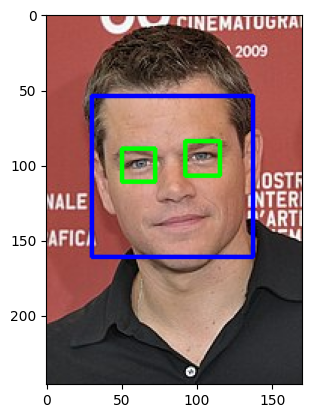

In [18]:
image = files_names[321]
img = cv2.imread(image)
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
print(faces)
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = img_gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)   
plt.imshow(cv2.cvtColor(face_img,cv2.COLOR_BGR2RGB),cmap = 'gray') 

**Finding face from the image using face cascade by CV2**

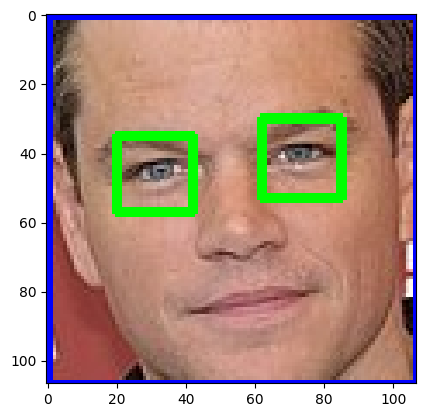

In [19]:
plt.imshow(cv2.cvtColor(roi_color,cv2.COLOR_BGR2RGB), cmap='gray')

In [20]:
def cropped_image(image):
    img = cv2.imread(image)
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
    for (x,y,w,h) in faces:
        face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = img_gray[y:y+h, x:x+w]
        roi_color = face_img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes)>=2: # it detected a face
            return roi_color

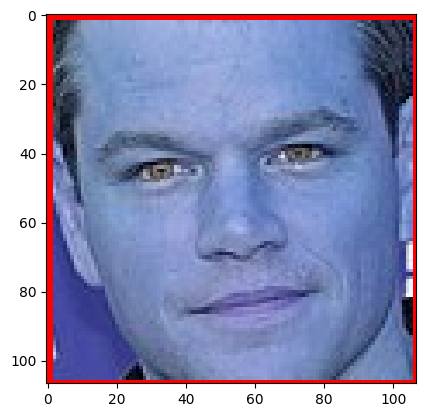

In [21]:
crop_img = cropped_image(image)
plt.imshow(crop_img)

**Wavelet Transforming the image to get more features from face**

In [23]:
import pywt
def w2d(img, mode='haar', level=1):
    imArray = img
    #convert to grayscale
    imArray = cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

**We can see how features can be shown by using wavelet transformation like mouth,eyes,nose etc.**

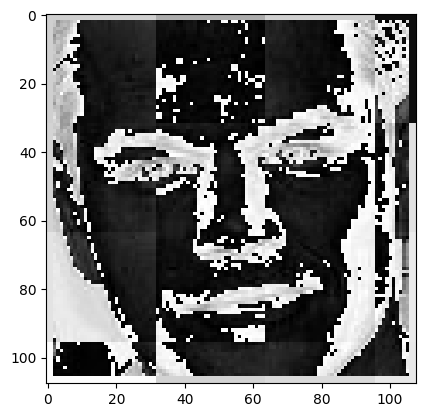

In [24]:
#wavelet Transformed Image
im_har = w2d(crop_img,'db1',5)
plt.imshow(im_har, cmap='gray')

**Performing for all the images in the dataset and stacking both color and wavelet image for better accuracies**

In [25]:
X = []
Y = []
for file in files_names:
    face_image = cropped_image(file)
    if face_image is not None:
        label = file.split('\\')[-2][2:]
        Y.append(labels.index(label))
        im_har = w2d(crop_img,'db1',5)
        scalled_raw_img = cv2.resize(face_image, (32, 32))
        scalled_im_har = cv2.resize(im_har,(32,32))
        combined_image = np.vstack((scalled_raw_img.reshape(-1,1),scalled_im_har.reshape(-1,1)))
        X.append(combined_image)


In [27]:
X = np.array(X).reshape(len(X),-1).astype(float)
X.shape

(250, 4096)

In [28]:
 from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.3,stratify = Y)

In [29]:
X_train = np.array(X_train,dtype = 'float32')
X_test = np.array(X_test,dtype = 'float32')
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)

In [30]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((175, 4096), (175,), (75, 4096), (75,))

In [31]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [32]:
model_svc = SVC()
model_svc.fit(X_train,Y_train)
y_pred = model_svc.predict(X_test)
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.41      0.71      0.52        21
           1       0.70      0.44      0.54        16
           2       0.50      0.12      0.19        17
           3       0.50      0.57      0.53        21

    accuracy                           0.48        75
   macro avg       0.53      0.46      0.44        75
weighted avg       0.52      0.48      0.45        75



In [33]:
from sklearn.naive_bayes import MultinomialNB
model_naive = MultinomialNB()
model_naive.fit(X_train,Y_train)
y_pred = model_naive.predict(X_test)
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.44      0.67      0.53        21
           1       0.55      0.69      0.61        16
           2       0.33      0.12      0.17        17
           3       0.59      0.48      0.53        21

    accuracy                           0.49        75
   macro avg       0.48      0.49      0.46        75
weighted avg       0.48      0.49      0.47        75



**Logistic Regression gave best performance**

In [36]:
from sklearn.linear_model import LogisticRegression
model_log = LogisticRegression(max_iter = 500)
model_log.fit(X_train,Y_train)
y_pred = model_log.predict(X_test)
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       0.76      0.81      0.79        16
           2       0.71      0.59      0.65        17
           3       0.70      0.76      0.73        21

    accuracy                           0.75        75
   macro avg       0.75      0.74      0.74        75
weighted avg       0.75      0.75      0.74        75



**Using standard scaler to improve the accuracy**

In [35]:
from sklearn.preprocessing import StandardScaler
standard = StandardScaler()
standard = standard.fit(X_train)
sta1 = standard.transform(X_train)
model_log = LogisticRegression(max_iter=200)
model_log.fit(sta1,Y_train)
y_pred = model_log.predict(standard.transform(X_test))
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       0.81      0.81      0.81        16
           2       0.71      0.71      0.71        17
           3       0.76      0.76      0.76        21

    accuracy                           0.77        75
   macro avg       0.77      0.77      0.77        75
weighted avg       0.77      0.77      0.77        75



**Downloading image from web**

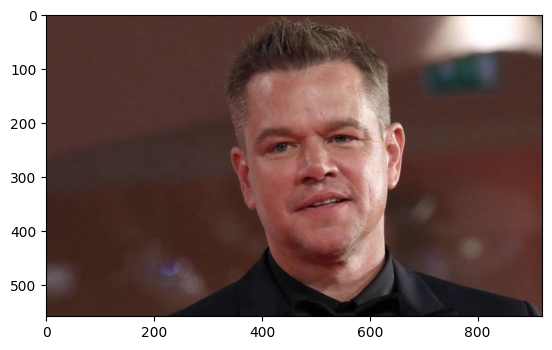

In [68]:
import urllib.request
from PIL import Image
  
urllib.request.urlretrieve(
  'https://img.buzzfeed.com/buzzfeed-static/complex/images/o3o899mz6tsznjqrqugu/matt-damon.jpg?downsize=920:*&output-format=auto&output-quality=auto',
   "gfg.png")
  
img = Image.open("gfg.png")
plt.imshow(img)

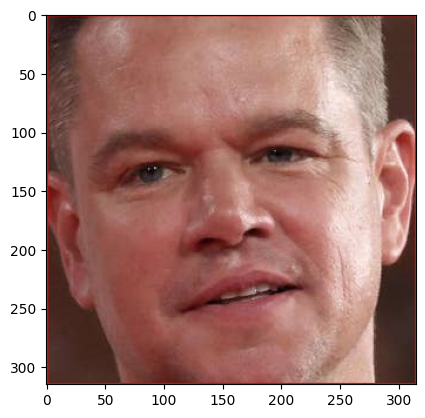

In [71]:
import numpy
img = numpy.array(img)
img2 = numpy.array(img)
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
for (x,y,w,h) in faces:
        face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = img_gray[y:y+h, x:x+w]
        face_image = face_img[y:y+h, x:x+w]

plt.imshow(face_image)


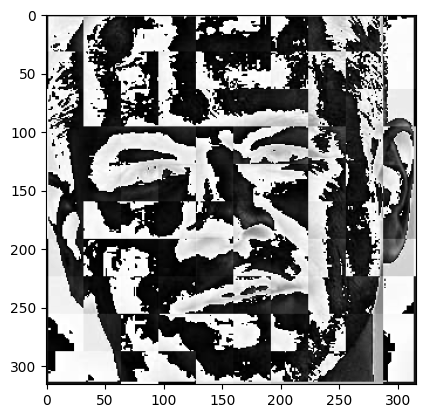

In [72]:
im_har = w2d(face_image,'db1',5)
plt.imshow(im_har, cmap='gray')

In [73]:
scalled_raw_img = cv2.resize(face_image, (32, 32))
scalled_im_har = cv2.resize(im_har,(32,32))
combined_image = np.vstack((scalled_raw_img.reshape(-1,1),scalled_im_har.reshape(-1,1)))
combined_image.shape

(4096, 1)

In [76]:
X = np.array(combined_image).reshape(1,-1).astype(float)
X.shape

(1, 4096)

In [80]:
label = model_log.predict(X)[0]
label

3

Text(0.5, 1.0, 'Matt Damon')

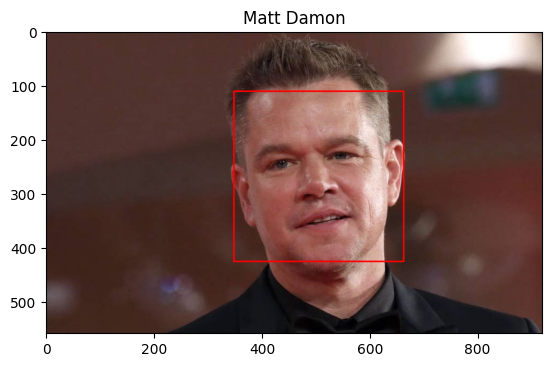

In [83]:
plt.imshow(img)
plt.title(labels[3])